### llm

In [1]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_tool = TavilySearchResults()
tools = [tavily_tool]
llm_with_tool = llm.bind_tools(tools)

In [4]:
from pydantic import BaseModel, Field
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")

In [5]:
from langgraph.graph import MessagesState
class AgentState(MessagesState):
    final_response: CityDetails

In [6]:
def call_model(state: AgentState):
    response = llm_with_tool.invoke(state['messages'])
    return {"messages": [response]}

### Tool

In [7]:
from langchain_core.tools import tool
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response

### Respond

In [8]:
model_with_structured_output = llm.with_structured_output(CityDetails)

In [9]:
from langchain_core.messages import HumanMessage
def respond(state: AgentState):
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    return {"final_response": response}

In [10]:
def route(state: AgentState):
    messages = state["messages"] 
    if messages[-1] .tool_calls:
        return "continue"
    else:
        return "respond"

In [11]:
from langgraph.graph import StateGraph,START, END
from langgraph.prebuilt import ToolNode


workflow = StateGraph(AgentState)

workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)

workflow.add_edge(START,"llm")
workflow.add_conditional_edges(
    "llm",
    route,
    {
        "continue": "tools",
        "respond": "respond",
    },
)
workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)

graph = workflow.compile()

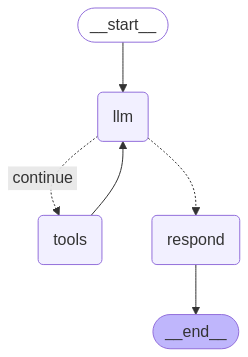

In [12]:
graph

In [18]:

answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for Patna?")]})

In [19]:
answer

{'messages': [HumanMessage(content='Tell me about the city details for Patna?', additional_kwargs={}, response_metadata={}, id='6d84216d-4018-45d7-950b-421889c84b28'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dys5', 'function': {'arguments': '{"query":"Patna city details"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 990, 'total_tokens': 1080, 'completion_time': 0.163636364, 'prompt_time': 0.042746063, 'queue_time': 0.239689406, 'total_time': 0.206382427}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8e0e2415-89df-4672-834b-84d1995d8c05-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Patna city details'}, 'id': 'call_dys5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 990, 'output_tokens': 90, 'total_tokens': 1080}),
  ToolMessage(content='[{"tit